In [1]:
import sys
import os
from tempfile import NamedTemporaryFile
from gc import collect

import netCDF4
import h5py
import numpy as np
import pylab as pl

sys.path.append('../util')
from meters import ThroughputMeter, clear_host_cache
from ncgen import *
from grids import *

In [2]:
def write_netcdf_file(timescale, time_major=True, grid=canada_5k):
    print("Creating a time-{} NetCDF file with {}x{} grid and {} time steps".format('major' if time_major else 'minor', grid['lon']['count'], grid['lat']['count'],len(timescale)))
    with NamedTemporaryFile(suffix='.nc', delete=False, dir='/app/tmp') as f:
        nc = make_nc(f.name, grid=grid, timescale=timescale, timemajor=time_major)
        nc.close()
    print("File size: {:.2f}Mb".format(os.path.getsize(f.name)/1024/1024))
    return f

In [3]:
def netcdf_read_test(f, time_major):
    print("Reading out with python-netCDF4 module...")
    # Open the file just created
    nc = netCDF4.Dataset(f.name, 'r')
    if time_major:
        with ThroughputMeter() as t:
            a = nc.variables['var_0'][0,:,:]
    else:
        with ThroughputMeter() as t:
            a = nc.variables['var_0'][:,:,0]
    res = ('python-netCDF4', time_major, len(timescale), t.megabytes_per_second(a))
    # python-netCDF4 seems to leak file descriptors
    # We have to take a lot of steps to make sure that the files get closed and that
    # the space gets reclaimed by the OS
    nc.close
    return res

In [4]:
def hdf5_read_test(f, time_major):
    print("Reading out with h5py module...")
    results = []
    # Open the file just created
    nc = h5py.File(f.name, 'r')
    if time_major:
        with ThroughputMeter() as t:
            a = nc['var_0'][0,:,:]
    else:
        with ThroughputMeter() as t:
            a = nc['var_0'][:,:,0]

    res = ('h5py', time_major, len(timescale), t.megabytes_per_second(a))
    # python-netCDF4 seems to leak file descriptors
    # We have to take a lot of steps to make sure that the files get closed and that
    # the space gets reclaimed by the OS
    nc.close
    return res

### Run through a few combinations of grids and timescales to test read throughput via h5py, followed by via python-netcdf4:

In [5]:
time_major = True
grids = [world_250k, world_125k, canada_5k, bc_400m]
ts = [timescales['seasonal'], timescales['annual'], timescales['monthly']] # Daily takes hours and hours to run #, timescales['daily']]

In [6]:
results = []

for grid in grids:
    for timescale in ts:
        testfile = write_netcdf_file(timescale, time_major=time_major, grid=grid)
        for read_with_h5py in [True, False]:
            !sync
            clear_host_cache()
            if read_with_h5py:
                results.append(hdf5_read_test(testfile, time_major))
            else:
                results.append(netcdf_read_test(testfile, time_major))
        print("Removing {}".format(testfile.name))
        os.remove(testfile.name)
        testfile.close()
        del testfile
        collect()


Creating a time-major NetCDF file with 128x64 grid and 17 time steps
File size: 0.54Mb
host cache cleared
Reading out with h5py module...
0.031 MB in 0.00378 seconds at 8.273 MB / sec
host cache cleared
Reading out with python-netCDF4 module...
0.031 MB in 0.00115 seconds at 27.284 MB / sec
Removing /app/tmp/tmpnqr002x6.nc
Creating a time-major NetCDF file with 128x64 grid and 150 time steps
File size: 4.70Mb
host cache cleared
Reading out with h5py module...
0.031 MB in 0.00126 seconds at 24.829 MB / sec
host cache cleared
Reading out with python-netCDF4 module...
0.031 MB in 0.00107 seconds at 29.114 MB / sec
Removing /app/tmp/tmp5887w44k.nc
Creating a time-major NetCDF file with 128x64 grid and 1800 time steps
File size: 56.26Mb
host cache cleared
Reading out with h5py module...
0.031 MB in 0.00141 seconds at 22.223 MB / sec
host cache cleared
Reading out with python-netCDF4 module...
0.031 MB in 0.000825 seconds at 37.871 MB / sec
Removing /app/tmp/tmp4_p80hy2.nc
Creating a time-ma

In [7]:
results

[('h5py', True, 17, 8.2726584195910124),
 ('python-netCDF4', True, 17, 27.283930058284763),
 ('h5py', True, 150, 24.828944875923469),
 ('python-netCDF4', True, 150, 29.114171479342513),
 ('h5py', True, 1800, 22.223126483553749),
 ('python-netCDF4', True, 1800, 37.871135509968219),
 ('h5py', True, 17, 61.666431427899319),
 ('python-netCDF4', True, 17, 94.042690582959636),
 ('h5py', True, 150, 60.999185573007566),
 ('python-netCDF4', True, 150, 90.503711375798375),
 ('h5py', True, 1800, 72.415469613259674),
 ('python-netCDF4', True, 1800, 78.193586875466067),
 ('h5py', True, 17, 200.79443343624717),
 ('python-netCDF4', True, 17, 226.09625113503697),
 ('h5py', True, 150, 185.45454545454547),
 ('python-netCDF4', True, 150, 211.68549151060265),
 ('h5py', True, 1800, 195.20831466714452),
 ('python-netCDF4', True, 1800, 232.29149452248313),
 ('h5py', True, 17, 191.37030927019791),
 ('python-netCDF4', True, 17, 189.28425855513308),
 ('h5py', True, 150, 174.08574991207595),
 ('python-netCDF4', 

## Summarize Results

In [11]:
h5py_results = [r[3] for r in results[0::2]]
netcdf4_results = [r[3] for r in results[1::2]]

In [12]:
h5py_results

[8.2726584195910124,
 24.828944875923469,
 22.223126483553749,
 61.666431427899319,
 60.999185573007566,
 72.415469613259674,
 200.79443343624717,
 185.45454545454547,
 195.20831466714452,
 191.37030927019791,
 174.08574991207595,
 190.62161257360165]

In [17]:
h5py_results[9:12]

[191.37030927019791, 174.08574991207595, 190.62161257360165]

In [13]:
netcdf4_results

[27.283930058284763,
 29.114171479342513,
 37.871135509968219,
 94.042690582959636,
 90.503711375798375,
 78.193586875466067,
 226.09625113503697,
 211.68549151060265,
 232.29149452248313,
 189.28425855513308,
 173.38242493959743,
 188.29298446202824]

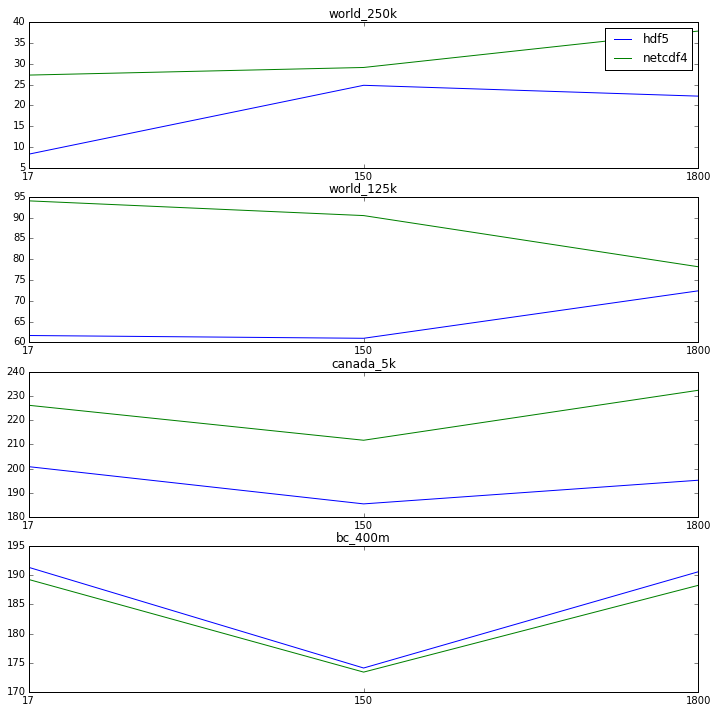

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
f.set_size_inches(12, 12)

ax1.plot(h5py_results[0:3], label="hdf5")
ax1.plot(netcdf4_results[0:3], label="netcdf4")
ax1.legend()
ax1.set_title("world_250k")
ax1.set_xticks(range(len(ts)))
ax1.set_xticklabels([len(x) for x in ts])

ax2.plot(h5py_results[3:6], label="hdf5")
ax2.plot(netcdf4_results[3:6], label="netcdf4")
ax2.set_title("world_125k")
ax2.set_xticks(range(len(ts)))
ax2.set_xticklabels([len(x) for x in ts])

ax3.plot(h5py_results[6:9], label="hdf5")
ax3.plot(netcdf4_results[6:9], label="netcdf4")
ax3.set_title("canada_5k")
ax3.set_xticks(range(len(ts)))
ax3.set_xticklabels([len(x) for x in ts])

ax4.plot(h5py_results[9:12], label="hdf5")
ax4.plot(netcdf4_results[9:12], label="netcdf4")
ax4.set_title("bc_400m")
ax4.set_xticks(range(len(ts)))
ax4.set_xticklabels([len(x) for x in ts])

### NetCDF file readout using python-netcdf4 is generally faster than with hdf5